# Sample NDVI visualization script

1. Import geemap and geetools
2. Display map on screen
3. Load desired shapefile and add to map
4. Filter Landsat 8 image colletion to region of interest and target range
5. Apply cloud mask, calculate NDVI and add results to the map
6. Retrieve individual mean NDVI value
7. Retrieve individual image dates
8. Plot mean NDVI vs dates**
    
**Note: the graph shown here has the approximate NDVI dates, for accurate results consult the javascript file**

## 1. Import geemap, geotools and other libraries

In [1]:
import os
import ee
import geetools as chart
import geemap
import matplotlib.pyplot as plt
import ipywidgets as widgets
import time


## 2. Display map on screen

In [20]:
Map = geemap.Map()
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

## 3. Load desired shapefile and add to map

In [23]:
## add desired farm path
farm_shp = "C:\\Users\\Wormface\\Desktop\\University of Michigan\\Academics\\3. Summer 2020\\ESA - Research\\Bella Paper\\Boundary NDVI\\Shapefiles by Class\\Artemio\\A\\Artemio_A.shp"
farm = geemap.shp_to_ee(farm_shp)               ## import shapefile as Google Earth Engine object
region = farm.geometry()                        ## get object boundaries
Map.addLayer(farm, {'color': 'red'}, 'Farm')    ## add to map with specified color and label
Map.centerObject(region, 10);                   ## center object in map

## 4. Filter Landsat 8 image colletion to region of interest and target range

In [42]:
## for other image collections visit "https://developers.google.com/earth-engine/datasets"
l8collection = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').filterDate('2017-01-01','2018-03-01').filterBounds(region);

## 5. Apply cloud mask, calculate NDVI and add results to the map

In [43]:
visParams = {'bands': ['B4','B3','B2'], 'min': 150, 'max': 2000}  # define visualization parameters

# apply cloud mask on pixel 322
# clear terrain, low confidence cloud and low confidence cirrus.
# check Landsat 8 Product Guide
# "https://www.usgs.gov/media/files/landsat-8-collection-1-land-surface-reflectance-code-product-guide"
l8masked = l8collection.map(lambda image: image.updateMask(image.select('pixel_qa').eq(322)));  

# Calculate NDVI
l8ndvi = l8masked.map(lambda img : img.addBands(img.normalizedDifference(['B5','B4']).rename('NDVI')))

# Add new layers to map
Map.addLayer(ee.Image(l8masked.first()), visParams, 'clouds masked')
Map.addLayer(ee.Image(l8collection.first()), visParams, 'original')
composite = l8ndvi.qualityMosaic('NDVI').clip(region);
Map.addLayer(composite.select('NDVI'),
           {'min': 0, 'max': 1, 'gamma':0.22}, 'ndvi');

## 6. Retrieve individual mean NDVI value

In [44]:
# use reducer function to filter information from object
my_vals = l8ndvi.map(lambda img : ee.Feature(region, img.normalizedDifference(['B5', 'B4']).rename('NDVI').reduceRegion(ee.Reducer.mean(),region)))
ndvi = my_vals.reduceColumns(ee.Reducer.toList(), ['NDVI']).get('list');
ndvi = ndvi.getInfo()

## 7. Retrieve individual image dates

In [45]:
# filter image dates and converto from epoch format to Year/month/day
dates = l8ndvi.reduceColumns(ee.Reducer.toList(), ["system:time_start"]).get('list')
date_old = dates.getInfo()
date_old.sort()
date_update = []

for date in date_old:
    
    date_correct = int(str(date)[:-3])
    update = time.strftime('%Y-%m-%d', time.localtime(date_correct))
    date_update.append(update)

## 8. Plot mean NDVI vs dates
**Note: actual date values are not accurate in the python script and ndvi data is not filtered for noise, for precise information consult javascript file**

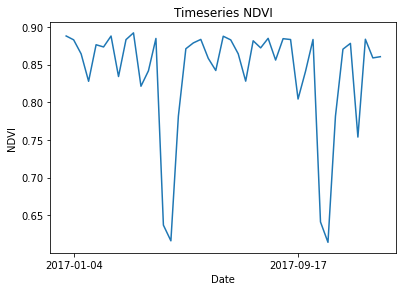

In [47]:
# Timeseries NDVI plot
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.plot(ndvi)
ax.set_xlabel('Date')
ax.set_ylabel('NDVI')
ax.set_title('Timeseries NDVI')
ticks = list(range(1,len(date_update)+1,30))
labels = list(map(lambda el : date_update[el],ticks))
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
plt.show()